In [154]:
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt
import operator
import matplotlib.pyplot as plt
import operator
%matplotlib inline
plt.style.use('bmh')

In [4]:
# example for how to create the data frame of people who voted "yes" for each bill in 1990
votes_yes_1990 = pd.read_csv("1990_yes_votes.csv")


In [5]:
# Given dataframe of people who voted "yes" for each bill in each year, generate dictionary for each year:
#   params: 
#       * vote_history -- a pandas df with cols "bill_number, display_name, first_name, id, last_name, party, state"
#                         representing yes votes from a particular year
#                         (could be an entry in the dictionary vote_yes)
#   returns:
#       * pairs_from_year -- a dictionary pairs_from_year such that 
#             pairs_from_year[(sen1_id, sen2_id)]= number of times senator1 & senator2 both voted "yes" in given year
#             sen1_id < sen2_id
def gen_pairs_from_vote(vote_history):
    pairs_from_year = {}
    for name, group in vote_history.groupby("bill_number"):
        print('anme', name,group)
        pairs_bill = itertools.combinations(group["id"], 2)
        for pair in list(pairs_bill):
            id1 = min(pair)
            id2 = max(pair)
            if (id1, id2) in pairs_from_year:
                pairs_from_year[(id1, id2)] += 1
            else:
                pairs_from_year[(id1, id2)] = 1
    return pairs_from_year

In [190]:
# given a year and a threshold of votes to exclude, constructs a weighted graph of senator voting behavior
#   params: 
#       year: year to make graph of
#       votes_to_exclude: if a bill has more than threshold votes of yes, we exclude it
#   returns:
#       weighted graph of senate voting behavior      
def create_graph(year, threshold):
    csv = str(year) + '_yes_votes.csv'
    df = pd.read_csv(csv)
    conn = sqlite3.connect(":memory:")
    df.to_sql('votes', conn, if_exists='replace', index=False)
    
    
    #finds number of bills in year
    query = '''
    SELECT count(bill_number) FROM
        (
            SELECT bill_number, count(1) as num_yes
            FROM votes
            GROUP BY 1
        )
        WHERE num_yes <='''+ str(threshold)+'''
    '''
    num_bills = pd.read_sql_query(query, conn)
    num_bills = num_bills.values[0][0]
    #selects all bills with fewer than votes_to_exclude yes votes
    query = '''
    SELECT * from votes
    where bill_number in
    (
        SELECT bill_number FROM
        (
            SELECT bill_number, count(1) as num_yes
            FROM votes
            GROUP BY 1
        )
        WHERE num_yes <='''+ str(threshold)+'''
        and num_yes >= 50
    )
    '''
    df_pruned = pd.read_sql_query(query, conn)
    df_pruned.to_sql('votes', conn, if_exists='replace', index=False)
    query = '''
    SELECT e1,e2,1.0*count(1)/''' +str(num_bills) +  ''' as weight from 
    (
        Select A.display_name as e1, B.display_name as e2 
        FROM votes A 
        JOIN votes B 
        on (A.bill_number = B.bill_number AND A.display_name != B.display_name)
    ) 
        WHERE e1 < e2
        GROUP BY 1,2
    '''
    weighted = pd.read_sql_query(query, conn)
    return nx.from_pandas_dataframe(weighted, 'e1', 'e2', 'weight')
    

In [191]:
#example on how to use create_graph
g1990 = create_graph(1990, 80)
nx.info(g1990)

'Name: \nType: Graph\nNumber of nodes: 101\nNumber of edges: 5014\nAverage degree:  99.2871'

In [1]:
# add D/R to each of the nodes
def create_party_dictionary(graph):
    party_dictionary = {}
    for n in nx.nodes(g1989):
        party = n.split("(")[1].split("-")[0]
        party_dictionary[n] = party
    return(party_dictionary)

In [31]:
#example of how to apply
g1989 = create_graph(1989, 70)
g1989_parties = create_party_dictionary(g1989)
nx.set_node_attributes(g1989, "party", g1989_parties)

In [143]:
# potential issue: the betweenness centralities seem to be the same for EVERYONE. 
# same results after playing with threshold
nx.degree_centrality(g1990)
nx.betweenness_centrality(g1990, weight='weight')

{u'Adams (D-WA)': 0.0,
 u'Akaka (D-HI)': 0.0,
 u'Armstrong (R-CO)': 0.2738720538720538,
 u'Baucus (D-MT)': 0.0,
 u'Bentsen (D-TX)': 0.0,
 u'Biden (D-DE)': 0.0,
 u'Bingaman (D-NM)': 0.0,
 u'Bond (R-MO)': 0.0,
 u'Boren (D-OK)': 0.0,
 u'Boschwitz (R-MN)': 0.0,
 u'Bradley (D-NJ)': 0.16543771043771044,
 u'Breaux (D-LA)': 0.0,
 u'Bryan (D-NV)': 0.0,
 u'Bumpers (D-AR)': 0.0,
 u'Burdick (D-ND)': 0.0,
 u'Burns (R-MT)': 0.0,
 u'Byrd (D-WV)': 0.0,
 u'Chafee (R-RI)': 0.0,
 u'Coats (R-IN)': 0.0,
 u'Cochran (R-MS)': 0.0,
 u'Cohen (R-ME)': 0.0,
 u'Conrad (D-ND)': 0.0,
 u'Cranston (D-CA)': 0.0,
 u"D'Amato (R-NY)": 0.0,
 u'Danforth (R-MO)': 0.0,
 u'Daschle (D-SD)': 0.0,
 u'DeConcini (D-AZ)': 0.0,
 u'Dixon (D-IL)': 0.0,
 u'Dodd (D-CT)': 0.0,
 u'Dole (R-KS)': 0.0,
 u'Domenici (R-NM)': 0.0,
 u'Durenberger (R-MN)': 0.0,
 u'Exon (D-NE)': 0.0,
 u'Ford (D-KY)': 0.0,
 u'Fowler (D-GA)': 0.0,
 u'Garn (R-UT)': 0.0,
 u'Glenn (D-OH)': 0.0,
 u'Gore (D-TN)': 0.0,
 u'Gorton (R-WA)': 0.0,
 u'Graham (D-FL)': 0.0,
 u'Gra

In [9]:
# max betweenness centrality over time
max_bets_over_time = {} # key: year, value: max betweenness score
for i in range(1989, 2013):
    g = create_graph(i,85)
    bets = nx.betweenness_centrality(g, weight='weight')
    max_bet = max(bets.iterkeys(), key=(lambda key: bets[key]))
    max_bets_over_time[i] = bets[max_bet]

print(max_bets_over_time)

{1989: 0.2674362674362674, 1990: 0.9203030303030303, 1991: 0.9933333333333333, 1992: 0.7576767676767677, 1993: 0.5474074074074075, 1994: 0.2804232804232804, 1995: 0.9531144781144784, 1996: 0.2520875420875421, 1997: 0.16364323507180648, 1998: 0.18563182848897133, 1999: 0.9921212121212121, 2000: 0.7368686868686869, 2001: 0.181026936026936, 2002: 0.9985858585858586, 2003: 0.7543805400948259, 2004: 0.9793547722119149, 2005: 0.33089397375111657, 2006: 0.16439909297052152, 2007: 0.4230000000000001, 2008: 0.6708238851095992, 2009: 0.8501463021105877, 2010: 0.7677257074101737, 2011: 0.8853232323232322, 2012: 0.7340410911839483}


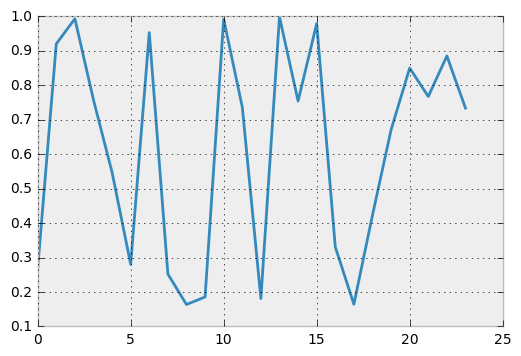

In [144]:
plt.plot(max_bets_over_time.values())

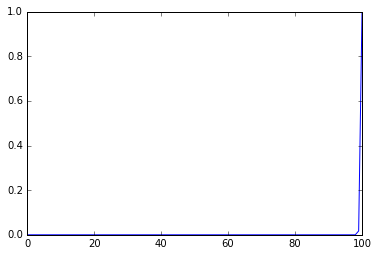

In [42]:
# plot a particular year's betwenness distribution
year = 1991
g = create_graph(year,85)
bets = nx.betweenness_centrality(g, weight='weight')
plt.plot(sorted(bets.values()))


In [181]:
# plot a particular year's eigenvector centrality distribution given threshold
def plot_eig(year, threshold):
    g = create_graph(year,threshold)
    eigs = nx.eigenvector_centrality(g, weight='weight')
    sorted_eigs = sorted(eigs.items(), key=operator.itemgetter(1))
    party_list = [str(senator[0][-5]) for senator in sorted_eigs]

    bar = plt.bar([i for i in range(len(party_list))],sorted(eigs.values()))
    for i in range(len(party_list)):
        if party_list[i] == 'R':
            bar[i].set_color('r')
        else:
            bar[i].set_color('b')
    plt.xlim([0,len(party_list)])
    plt.ylabel('Eigenvector centrality')
    plt.title('Distribution of eigenvector centrality for ' + str(year))
    plt.show()

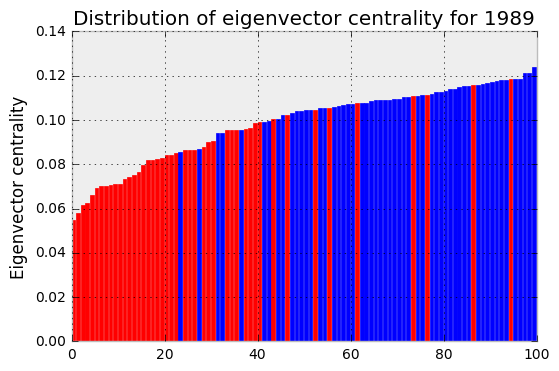

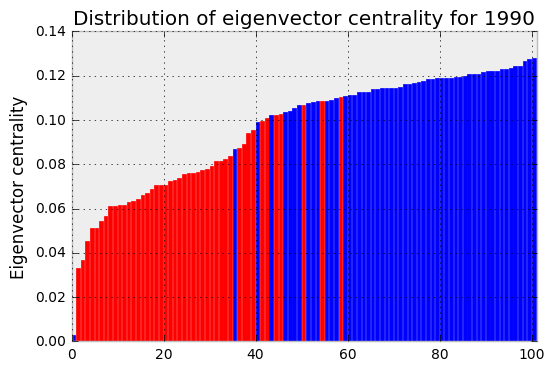

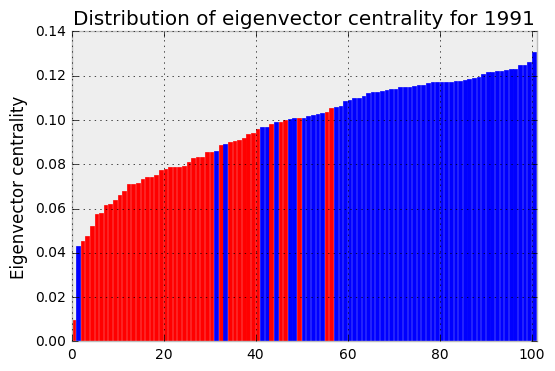

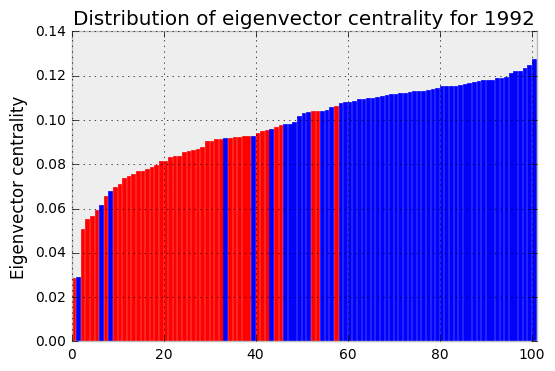

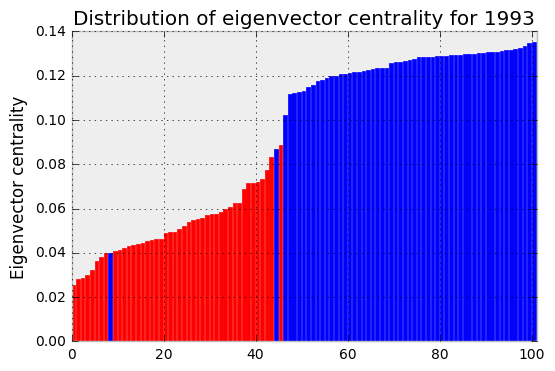

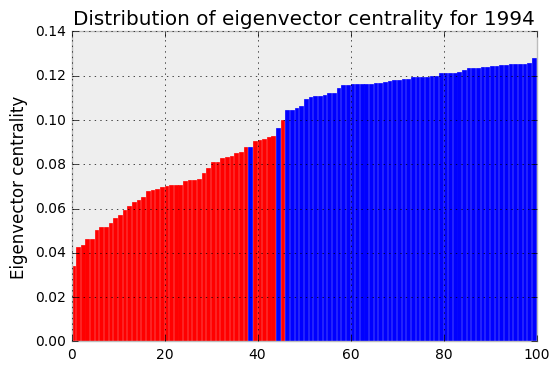

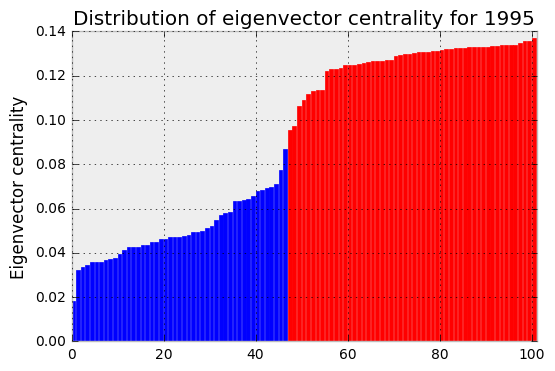

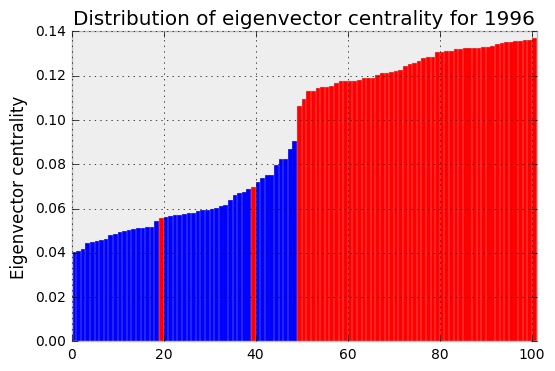

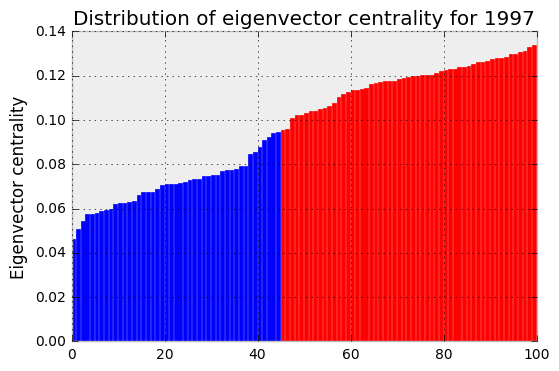

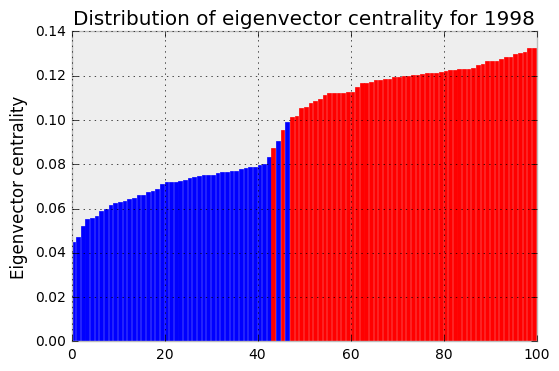

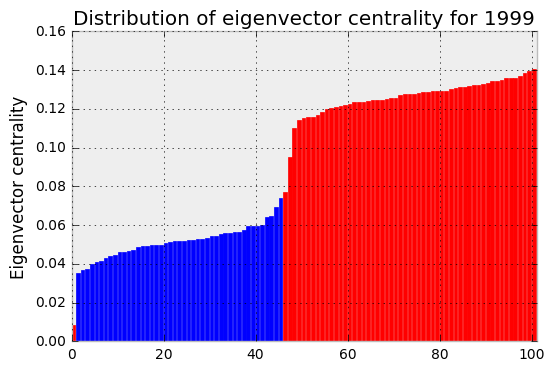

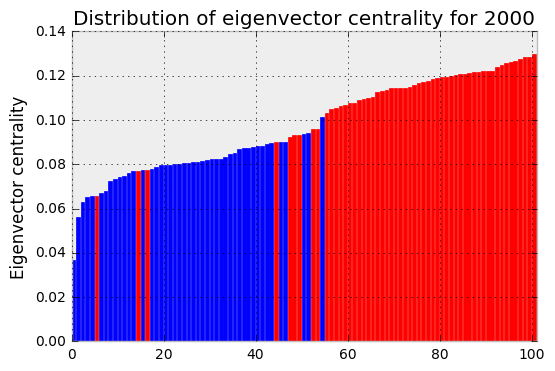

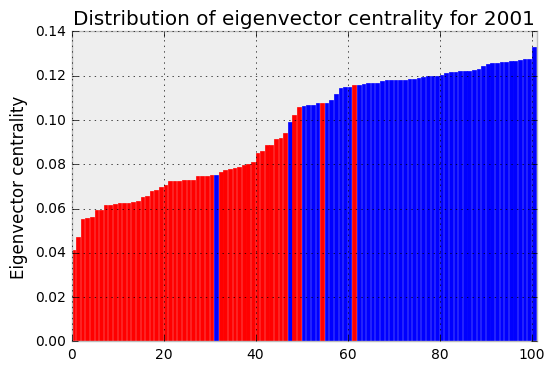

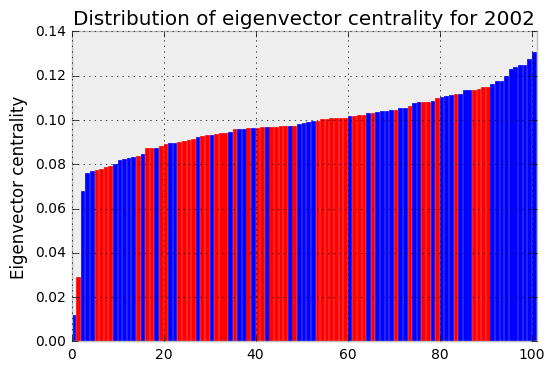

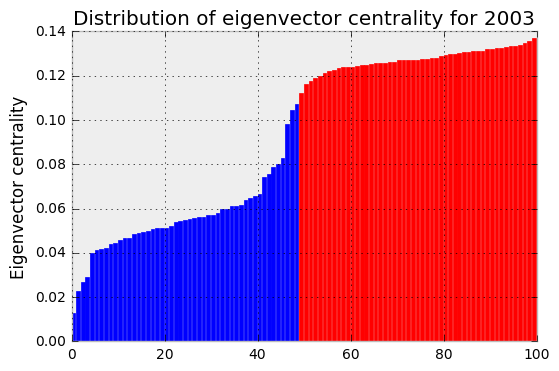

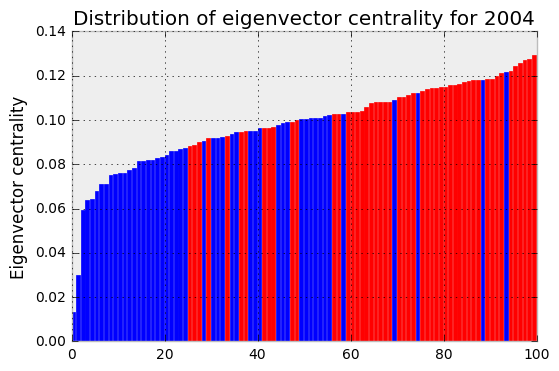

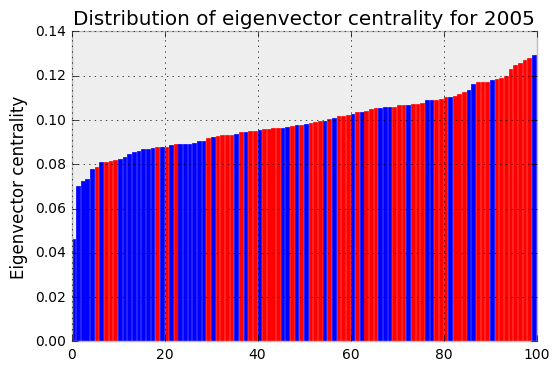

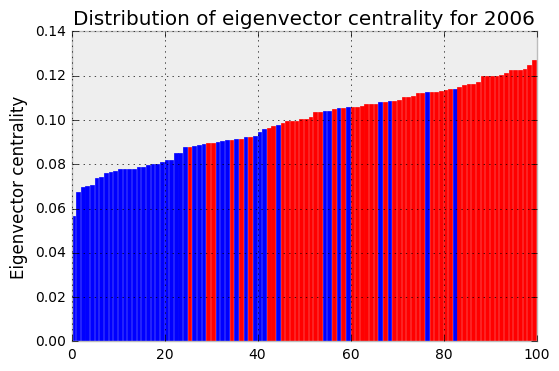

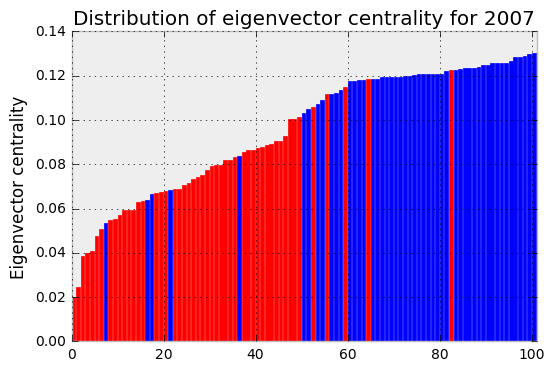

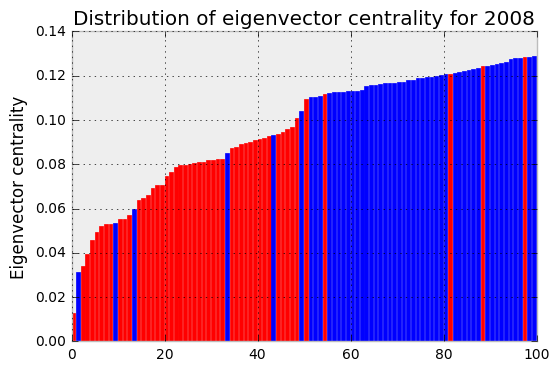

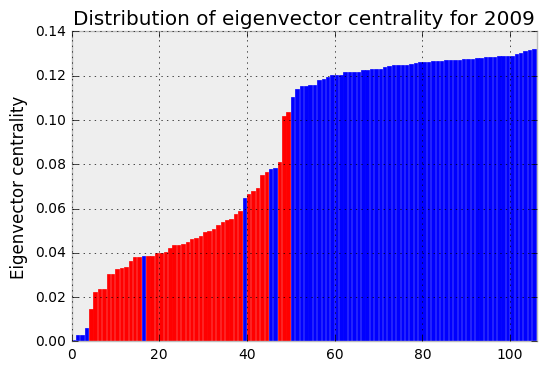

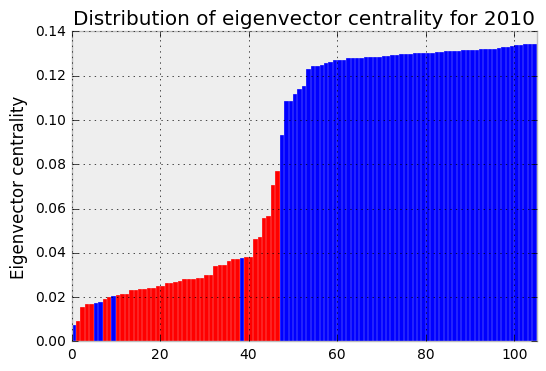

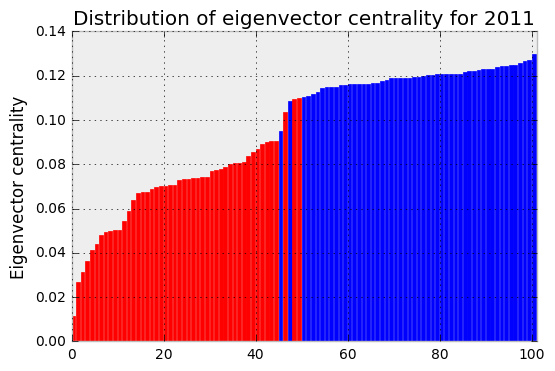

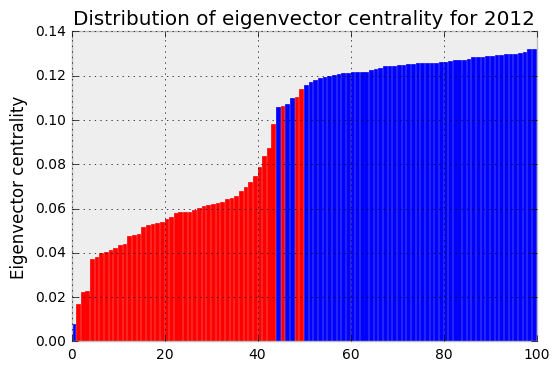

In [182]:
for year in range(1989, 2013):
    plot_eig(year, 90)

# Exporting to gephi

In [13]:
gephi_graph_1990 = nx.write_graphml(g1990, "gephi_1990.graphml")

In [32]:
gephi_graph_1989 = nx.write_graphml(g1989, "gephi_1989.graphml")

In [37]:
g2010 = create_graph(2010, 80)
#g2010_parties = create_party_dictionary(g2010)
#nx.set_node_attributes(g2010, "party", g2010_parties)
gephi_graph_2010 = nx.write_graphml(g2010, "gephi_2013.graphml")

# Louvain community detection

In [ ]:
import community
#try and get community to work / install on your computer
# and then run this cell
out = []
for year in range(1989, 2013):
    G = create_graph(year, 90)
    #G = nx.erdos_renyi_graph(30, 0.05)
    nx.transitivity(G)
    
    #find modularity
    part = community.best_partition(G)
    mod = community.modularity(part,G)
    print mod
    #unsure what datatype mod is, but there should be an int associated with it 
    out.append(mod)
    

plt.plot(out)
plt.xlabel('Years since 1989')
plt.ylabel('Modularity')
plt.title('Modularity in Congress over time')

# Calculating threshold (deprecated now that we switched to prop weighing)

In [185]:
#for each threshold value between 0 and 100, determinds how many senators have that threshold
def avg_degree_by_threshold(year):
    avg_degree = []
    g = create_graph(year, 100)
    nodes = nx.number_of_nodes(g)
    for threshold in range(0, 100):
        g = create_graph(year, threshold)
        degrees = g.degree(weight = None)
        sum_of_edges = sum(degrees.values())
        
        avg_degree.append(sum_of_edges/nodes)
    return avg_degree


KeyboardInterrupt: 

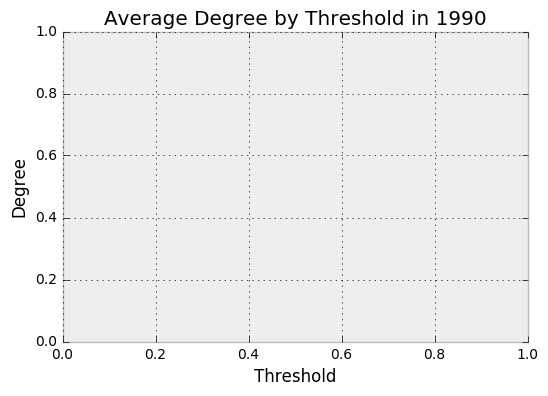

In [186]:
plt.title('Average Degree by Threshold in 1990')
plt.xlabel('Threshold')
plt.ylabel('Degree')
plt.plot(avg_degree_by_threshold(1990))

In [42]:
#given a year, threhold, and num_edges to exclude, prunes a graph to exclude 
def prune_weight_scores(year, threshold, num_edges):
    g = create_graph(year,threshold)
    weight = []
    
    #creates edge list
    for edge in g.edges(data = True):
        weight.append(edge[2]['weight'])
    
    #finds cutoff
    vote_threshold = sorted(weight)[4950 - num_edges]
    
    #prunes list 
    out = []
    for edge in g.edges(data = True):
        if edge[2]['weight'] > vote_threshold:
            out.append(edge)
    return nx.from_edgelist(out)

In [43]:
#example of how to use
g = prune_weight_scores(2013, 70, 3000)
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 101\nNumber of edges: 3223\nAverage degree:  63.8218'

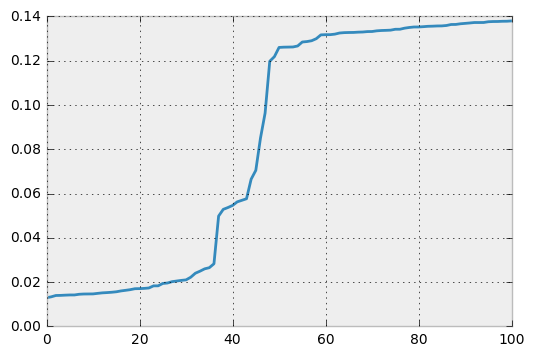

In [46]:
year = 2013
g = prune_weight_scores(year,70, 3000)
eigs = nx.eigenvector_centrality(g, weight='weight')
plt.plot(sorted(eigs.values()))

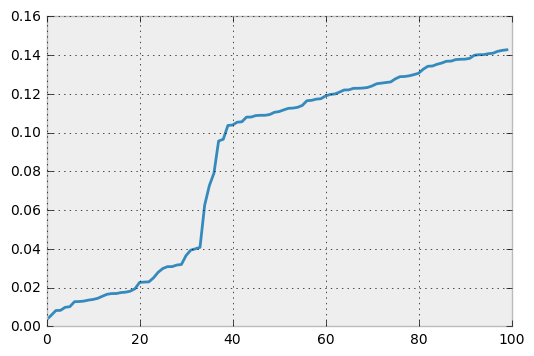

In [47]:
year = 1989
g = prune_weight_scores(year,70, 3000)
eigs = nx.eigenvector_centrality(g, weight='weight')
plt.plot(sorted(eigs.values()))

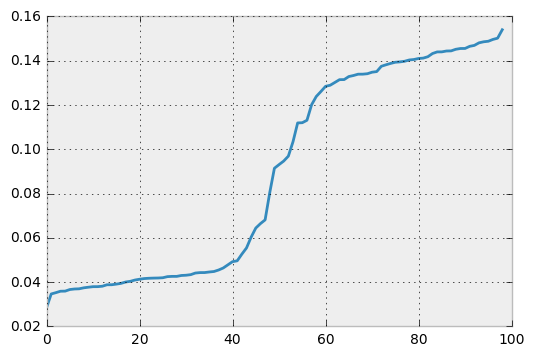

In [50]:
year = 2004
g = prune_weight_scores(year,70, 3000)
eigs = nx.eigenvector_centrality(g, weight='weight')
plt.plot(sorted(eigs.values()))

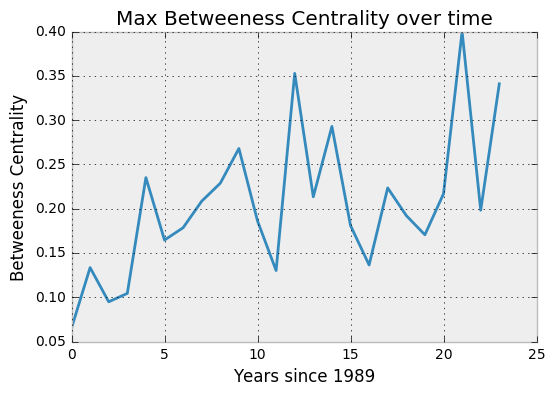

In [61]:
# max betweenness centrality over time
max_bets_over_time = {} # key: year, value: max betweenness score
for i in range(1989, 2013):
    g = prune_weight_scores(i,70, 3000)
    bets = nx.betweenness_centrality(g, weight='weight')
    max_bet = max(bets.iterkeys(), key=(lambda key: bets[key]))
    max_bets_over_time[i] = bets[max_bet]

plt.title('Max Betweeness Centrality over time')
plt.xlabel('Years since 1989')
plt.ylabel('Betweeness Centrality')
plt.plot(max_bets_over_time.values())

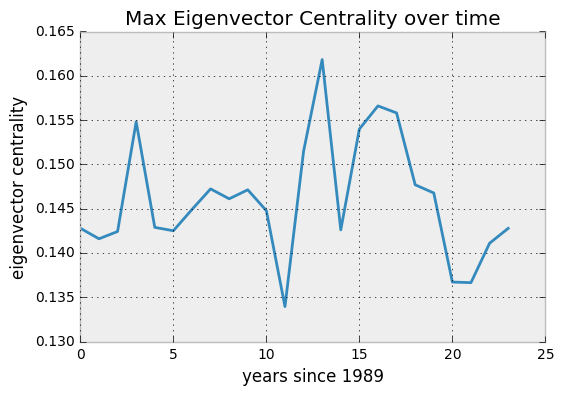

In [60]:
out = []
people = []
for year in range(1989,2013):
    g = prune_weight_scores(year,70, 3000)
    eigs = nx.eigenvector_centrality(g, weight='weight')
    out.append(max(eigs.values()))
plt.title('Max Eigenvector Centrality over time')
plt.xlabel('years since 1989')
plt.ylabel('eigenvector centrality')
plt.plot(out)

In [58]:
g = prune_weight_scores(year,70, 3000)
eigs = nx.eigenvector_centrality(g, weight='weight')

[0.01548736689580864, 0.14022230532948973, 0.1393351979974769, 0.027358640810750658, 0.016832291097135778, 0.10053227553861722, 0.12443984776053256, 0.14173141865881106, 0.021333457693625404, 0.13425491397553616, 0.13246193284770413, 0.014641945351448601, 0.06805224292188841, 0.12869315178703764, 0.013871812846307861, 0.13531799174332898, 0.13469694923257847, 0.1338410003123272, 0.1336198887078137, 0.12829505238747732, 0.12037506609579741, 0.021481149958661776, 0.08965673543682237, 0.014498769940682941, 0.017025168943592083, 0.01598135138761231, 0.13017738599302386, 0.01611211213476047, 0.1396025641096755, 0.018423771147575707, 0.13750829758662725, 0.02999374501793575, 0.01448258004778908, 0.12472087249691795, 0.11509636982364403, 0.13235638094068328, 0.015215328721894341, 0.1336899285237147, 0.015351341807310768, 0.13222313699288443, 0.022184883322065037, 0.015810986905275125, 0.12792844250894433, 0.01629028095884078, 0.14029551190827189, 0.13973476157790615, 0.10304766914810724, 0.01

In [187]:
def plot_edge_weights(year, threshold):
    g = create_graph(year, threshold)
    g_parties = create_party_dictionary(g)
    #nx.set_node_attributes(g, "party", g_parties)
    weight_list = []
    for edge in g.edges(data = True):
        weight_list.append(edge[2]['weight'])

    l = sorted(weight_list)
    type(l)
    print 'number of edges: ' + str(len(l))
    plt.hist(l)
    plt.xlabel('weight of edge')
    plt.ylabel('frequency')
    plt.title('histogram of senate pair weights with threshold ' + str(threshold))

270
   Unnamed: 0  bill_number     display_name first_name    id last_name party  \
0           1            0     Adams (D-WA)      Brock  S180     Adams     D   
1           2            0     Akaka (D-HI)     Daniel  S213     Akaka     D   
2           3            0    Baucus (D-MT)        Max  S127    Baucus     D   
3           4            0     Biden (D-DE)     Joseph  S010     Biden     D   
4           5            0  Bingaman (D-NM)       Jeff  S167  Bingaman     D   

  state  
0    WA  
1    HI  
2    MT  
3    DE  
4    NM  
number of edges: 5049


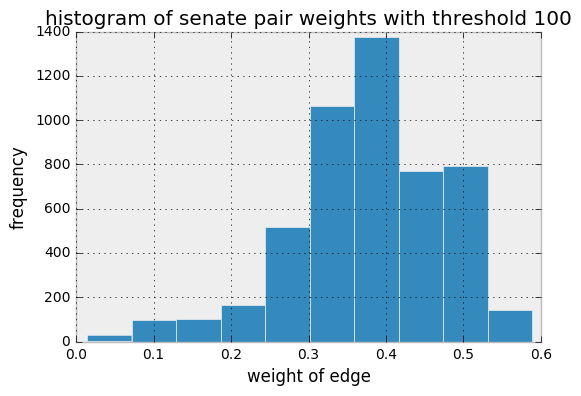

In [135]:
plot_edge_weights(1992, 100)

234
   Unnamed: 0  bill_number    display_name first_name    id last_name party  \
0         359            5    Adams (D-WA)      Brock  S180     Adams     D   
1         360            5    Akaka (D-HI)     Daniel  S213     Akaka     D   
2         361            5    Biden (D-DE)     Joseph  S010     Biden     D   
3         362            5  Bradley (D-NJ)       Bill  S132   Bradley     D   
4         363            5    Bryan (D-NV)    Richard  S206     Bryan     D   

  state  
0    WA  
1    HI  
2    DE  
3    NJ  
4    NV  
number of edges: 5049


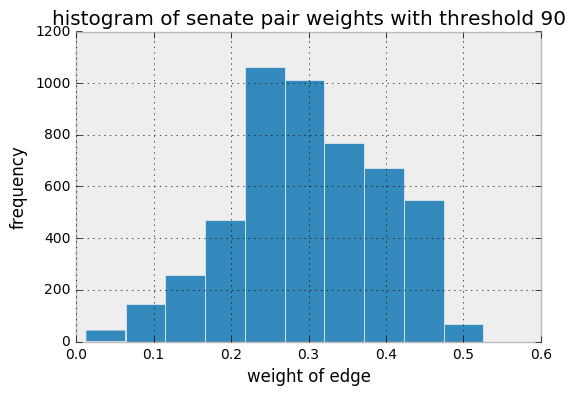

In [136]:
 plot_edge_weights(1992, 90)

197
   Unnamed: 0  bill_number    display_name first_name    id last_name party  \
0         359            5    Adams (D-WA)      Brock  S180     Adams     D   
1         360            5    Akaka (D-HI)     Daniel  S213     Akaka     D   
2         361            5    Biden (D-DE)     Joseph  S010     Biden     D   
3         362            5  Bradley (D-NJ)       Bill  S132   Bradley     D   
4         363            5    Bryan (D-NV)    Richard  S206     Bryan     D   

  state  
0    WA  
1    HI  
2    DE  
3    NJ  
4    NV  
number of edges: 5049


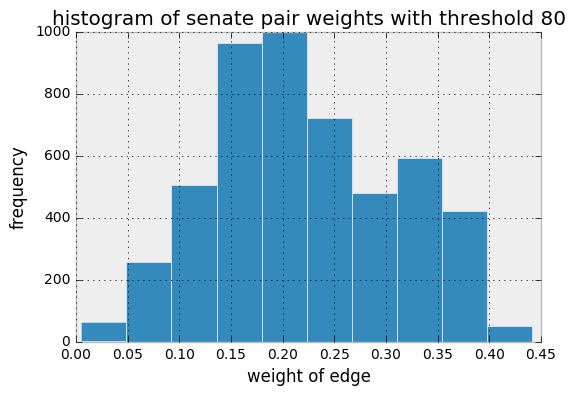

In [137]:
plot_edge_weights(1992, 80)

   Unnamed: 0  bill_number      display_name first_name    id  last_name  \
0         200            3  Alexander (R-TN)      Lamar  S289  Alexander   
1         201            3    Baldwin (D-WI)      Tammy  S354    Baldwin   
2         202            3     Baucus (D-MT)        Max  S127     Baucus   
3         203            3     Begich (D-AK)       Mark  S319     Begich   
4         204            3     Bennet (D-CO)    Michael  S330     Bennet   

  party state  
0     R    TN  
1     D    WI  
2     D    MT  
3     D    AK  
4     D    CO  
number of edges: 5154


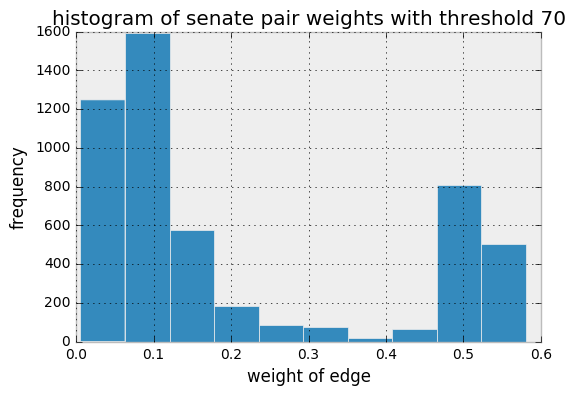

In [126]:
plot_edge_weights(2013, 70)